# **Neural network**

In [41]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, get_scorer, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
sys.path.append('..')
from utils import sensitivity_score, specificity_score

#### **How it works**
In this case, a neural network (NN) is used to predict the relative position of a cyclist in a race. Then, for each test example (i.e., each cyclist), the percentage of cyclists corresponding to the top 20 cyclists in the overall ranking is calculated.

For example, if there are 40 cyclists in a race, 50% of 40 equals 20 cyclists. The relative position predicted by the neural network is used to determine whether the cyclist belongs to the top 20. If the predicted relative position is less than 50% of the total number of cyclists (i.e., among the top 20), the cyclist is classified as "Top 20." Otherwise, they are classified as "Not Top 20."

In [30]:
train_data = pd.read_csv('../dataset/train_data.csv')
test_data = pd.read_csv('../dataset/test_data.csv')
test_labels = pd.read_csv('../dataset/test_labels.csv')

For the NN lables are relative position 

In [31]:
train_labels = train_data['relative_position']

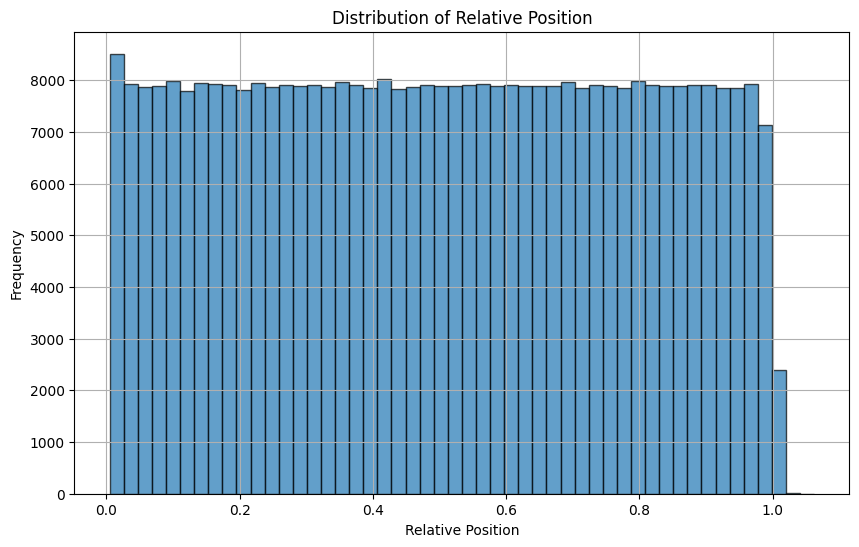

In [46]:
plt.figure(figsize=(10, 6))
plt.hist(bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('Relative Position')
plt.ylabel('Frequency')
plt.title('Distribution of Relative Position')
plt.grid(True)
plt.show()

#### **Feature to keep**

In [32]:
features_to_keep = ['climb_total', 'cyclist_age', 'cyclist_level', 'cyclist_experience',
       'avg_relative_position', 'position_entropy', 'top_20_entropy']

train_data = train_data[features_to_keep]
test_data = test_data[features_to_keep+['cyclist_number']]

numeric_transformer = StandardScaler()

In [33]:
# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, features_to_keep)]
)

In [34]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, r2_score
from imblearn.combine import SMOTETomek

# NN regression
clf = MLPRegressor(random_state=42)
resempling = SMOTETomek(random_state=42)

# Pipeline 
model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("clf", clf)
    ]
)

parameters = {
    'clf__hidden_layer_sizes': [(50, 50), (100, 50), (150,75), (50, 30, 10), (70, 35, 12), (150, 75, 25), (30, 20, 10, 5), (50, 30, 20, 10)],
    'clf__activation': ['relu', 'tanh', 'logistic'],
    'clf__alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.07, 0.1, 0.3, 0.5, 0.7],
    'clf__learning_rate': ['constant', 'adaptive'],
    'clf__learning_rate_init': [0.001, 0.01, 0.1],
    'clf__batch_size': ['auto', 16, 32, 64, 128],
    'clf__tol': [1e-4, 1e-3, 1e-2, 1e-1],
    'clf__max_iter': [100, 200, 500]  
}


scoring = {
    'mse': make_scorer(mean_squared_error),
    'r2': make_scorer(r2_score),
}


rscv = RandomizedSearchCV(
    model,
    param_distributions=parameters,
    scoring='neg_mean_squared_error',  
    n_iter=1,  
    cv=2,  # 5-fold cross-validation
    verbose=1,  
    n_jobs=-1,  
    random_state=10, 
    refit=True, 
    return_train_score=True
)

rscv.fit(train_data, train_labels)


Fitting 2 folds for each of 1 candidates, totalling 2 fits


RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['climb_total',
                                                                                'cyclist_age',
                                                                                'cyclist_level',
                                                                                'cyclist_experience',
                                                                                'avg_relative_position',
                                                                                'position_entropy',
                                                                                'top_20_entropy'])])),
                                             ('clf',
                                              MLPRegressor(random_state=42))]),
                   n_iter=1, n_jobs=-1,
                   param_distributions={'clf__activation'...
                                        'clf__hidden_layer_sizes': [(50, 50),
                                                                    (100, 50),
                                                                    (150, 75),
                                                                    (50, 30,
                                                                     10),
                                                                    (70, 35,
                                                                     12),
                                                                    (150, 75,
                                                                     25),
                                                                    (30, 20, 10,
                                                                     5),
                                                                    (50, 30, 20,
                                                                     10)],
                                        'clf__learning_rate': ['constant',
                                                               'adaptive'],
                                        'clf__learning_rate_init': [0.001, 0.01,
                                                                    0.1],
                                        'clf__max_iter': [100, 200, 500],
                                        'clf__tol': [0.0001, 0.001, 0.01, 0.1]},
                   random_state=10, return_train_score=True,
                   scoring='neg_mean_squared_error', verbose=1)

## Model Assessment

### Training scores:

In [35]:
# Extract scores and best model
best_model = rscv.best_estimator_
results = rscv.cv_results_

for mean_score, std_score, params in zip(results['mean_train_score'], results['std_train_score'], results['params']):
    print(f"Mean Train Score: {mean_score:.4f} (Std: {std_score:.4f}) with parameters: {params}")

Mean Train Score: -0.0687 (Std: 0.0001) with parameters: {'clf__tol': 0.001, 'clf__max_iter': 100, 'clf__learning_rate_init': 0.01, 'clf__learning_rate': 'adaptive', 'clf__hidden_layer_sizes': (50, 30, 10), 'clf__batch_size': 128, 'clf__alpha': 0.07, 'clf__activation': 'logistic'}


### Validation scores:

In [36]:
for mean_score, std_score, params in zip(results['mean_test_score'], results['std_test_score'], results['params']):
    print(f"Mean Train Score: {mean_score:.4f} (Std: {std_score:.4f}) with parameters: {params}")

Mean Train Score: -0.0687 (Std: 0.0004) with parameters: {'clf__tol': 0.001, 'clf__max_iter': 100, 'clf__learning_rate_init': 0.01, 'clf__learning_rate': 'adaptive', 'clf__hidden_layer_sizes': (50, 30, 10), 'clf__batch_size': 128, 'clf__alpha': 0.07, 'clf__activation': 'logistic'}


In [37]:
"""from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

# Number of epochs
n_epochs = 50

train_losses = []
validation_losses = []

for epoch in range(n_epochs):

    # fit the model on the training data
    best_model.fit(train_data, train_labels)
    
    # prediction on the training and validation data
    train_predictions = best_model.predict(train_data)
    validation_predictions = best_model.predict(test_data)
    
    train_loss = mean_squared_error(train_labels, train_predictions)
    validation_loss = mean_squared_error(test_labels, validation_predictions)
    
    train_losses.append(train_loss)
    validation_losses.append(validation_loss)
    
    print(f"Epoch {epoch+1}/{n_epochs} - Training Loss: {train_loss:.4f} - Validation Loss: {validation_loss:.4f}")


plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, n_epochs+1), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()"""

'from sklearn.metrics import mean_squared_error\n\nimport matplotlib.pyplot as plt\n\n# Number of epochs\nn_epochs = 50\n\ntrain_losses = []\nvalidation_losses = []\n\nfor epoch in range(n_epochs):\n\n    # fit the model on the training data\n    best_model.fit(train_data, train_labels)\n    \n    # prediction on the training and validation data\n    train_predictions = best_model.predict(train_data)\n    validation_predictions = best_model.predict(test_data)\n    \n    train_loss = mean_squared_error(train_labels, train_predictions)\n    validation_loss = mean_squared_error(test_labels, validation_predictions)\n    \n    train_losses.append(train_loss)\n    validation_losses.append(validation_loss)\n    \n    print(f"Epoch {epoch+1}/{n_epochs} - Training Loss: {train_loss:.4f} - Validation Loss: {validation_loss:.4f}")\n\n\nplt.figure(figsize=(10, 6))\nplt.plot(range(1, n_epochs+1), train_losses, label=\'Training Loss\')\nplt.plot(range(1, n_epochs+1), validation_losses, label=\'Valid

In [38]:
predictions = best_model.predict(test_data.drop(columns=['cyclist_number']))
test_data['predicted_top20'] = predictions
mse = mean_squared_error(test_labels, predictions)
r2 = r2_score(test_labels, predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared: {r2}")


Mean Squared Error (MSE): 0.25918308458940426
R-squared: -1.0728317278404154


In [39]:
# to classify if the cyclist is in the top 20 or not
# use treshold 20 / number of cyclists
# create the column of the bninary classification
test_data['predicted_top20'] = np.where(
    predictions * test_data['cyclist_number'] < 20,  
    1, 
    0   
)

print(classification_report(test_data['predicted_top20'], test_labels['top_20']))


              precision    recall  f1-score   support

           0       1.00      0.85      0.92     35345
           1       0.01      0.62      0.01        61

    accuracy                           0.85     35406
   macro avg       0.50      0.74      0.47     35406
weighted avg       1.00      0.85      0.92     35406



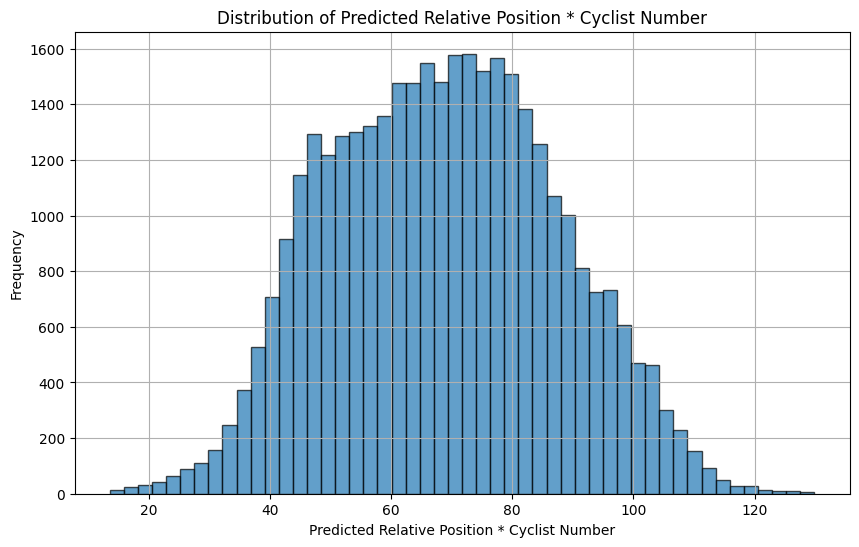

In [45]:
temp_df = predictions * test_data['cyclist_number']
plt.figure(figsize=(10, 6))
plt.hist(temp_df, bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('Predicted Relative Position * Cyclist Number')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Relative Position * Cyclist Number')
plt.grid(True)
plt.show()

In [44]:
test_data['predicted_top20'].value_counts()

predicted_top20
0    35345
1       61
Name: count, dtype: int64

Accuracy: 0.8539230638874767
Recall: 0.007326007326007326
Precision: 0.6229508196721312
Sensitivity: 0.007326007326007326
Specificity: 0.9992388894404183
F1 Score: 0.014481707317073171
ROC AUC Score: 0.5032824483832128


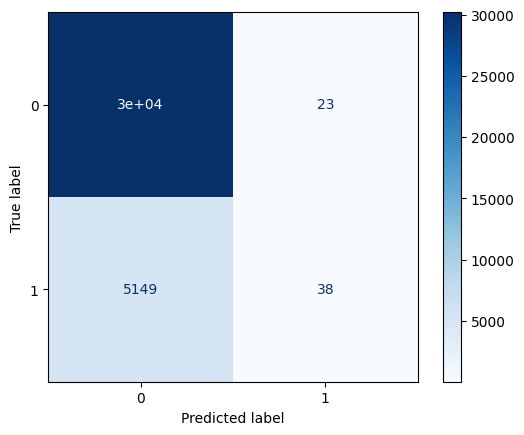

In [42]:
# Predict on the test data
test_predictions = test_data['predicted_top20']

# Calculate evaluation metrics
accuracy = accuracy_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions)
sensitivity_score = sensitivity_score(test_labels, test_predictions)
specificity_score = specificity_score(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions)
roc_auc = roc_auc_score(test_labels, test_predictions)
conf_matrix = confusion_matrix(test_labels, test_predictions)

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"Sensitivity: {sensitivity_score}")
print(f"Specificity: {specificity_score}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()
